### Attempt to see how accurate is the audio reconstruction from the features 

Basically, we want to see if the features extracted from a reconstructed audio are close to the features extracted from the original audio
This is relevant for my work because from the AdvEx features that we obtain after backprop, I will reconstruct the adversarial audio, compress it and then feed those features again 

#### Start with any original raw (uncompressed) audio sample

In [1]:
import numpy as np
from scipy.io.wavfile import read
import librosa
import sys
import matplotlib.pyplot as plt
%matplotlib inline 

utt="314piwm-20130617-xuo-b0251"
#1028-20100710-hne-ar-05

utt_wav=utt+".wav"
fs, orig_raw_wav = read(utt_wav)
orig_raw_wav_librosa, fs_librosa = librosa.load(utt_wav,sr=fs) # loads a wrong frequency !!!
print("The fs, shape, max and min value of original raw wav utt " + utt_wav + " read with scipy.io.wavfile.read are: ", fs, orig_raw_wav.shape, orig_raw_wav.max(), orig_raw_wav.min())
print("The fs, shape, max and min value of original raw wav utt " + utt_wav + " read with librosa are: ", fs_librosa, orig_raw_wav_librosa.shape, orig_raw_wav_librosa.max(), orig_raw_wav_librosa.min()) 

## So apparently, librosa automatically normalizes the values of the data


The fs, shape, max and min value of original raw wav utt 314piwm-20130617-xuo-b0251.wav read with scipy.io.wavfile.read are:  16000 (84000,) 14225 -15773
The fs, shape, max and min value of original raw wav utt 314piwm-20130617-xuo-b0251.wav read with librosa are:  16000 (84000,) 0.43411255 -0.48135376


In [2]:
# Now read the features from the data.json as they were computed with the following pipeline from the main script:
# run.sh -> make_fbank_librosa.sh -> compute-fbank-feats.py -> feats.scp, feats.ark -> data2json.sh -> data.json 
import kaldiio

orig_feat_from_json_path="data/all_en_raw_ONLY_fbanks-Librosa_NO-cmvn_22.02.2020/features/raw_fbank_all_en_raw_ONLY_fbanks-Librosa_NO-cmvn_22.02.2020.1.ark:195004"
#### !!!!!!!!!!! Above features from json are only for utterance 1028-20100710-hne-ar-05

orig_feat_from_json=kaldiio.load_mat(orig_feat_from_json_path)

#######################################
##  Calculate again the features with the exact steps from compute-fbank-feats.py and see if we get the same results
orig_wav_float32 = orig_raw_wav.astype(np.float32)
# print("Audio samples from orig wav: %s" %(orig_raw_wav[5400:5430]))
# print("Max value in orig wav is: %s" %(orig_wav.max()))
# print("Audio samples from wav - float 32: %s" %(orig_wav_float32[5400:5430]))
# print("Max value in wav - float 32 is: %s" %(orig_wav_float32.max()))
## Obs. Based on the values, float16 does just an approximation of the values, while float32 doesn't change them
### Now apply the normalization 
#  array = array / (1 << (args.normalize - 1))
bit_depth=16
orig_norm = orig_wav_float32 / (1 << (bit_depth-1))

sys.path.insert(0, '/home/iustina/espnet/')
from espnet.transform.spectrogram import logmelspectrogram

feat_recalc = logmelspectrogram(
                x=orig_norm,
                fs=16000,
                n_mels=80,
                n_fft=512,
                n_shift=160,
                win_length=512,
                window="hann",
                fmin=80,
                fmax=7800) ##

In [3]:
print("The shape, max and min values of features from the raw wav utt " + utt_wav + " as computed by run script and stored in .json and .ark files are: ", orig_feat_from_json.shape, orig_feat_from_json.max(), orig_feat_from_json.min())
print("The shape, max and min values of recalculated features as in compute-fbank-feats.py (float32, norm, logmelspectrogram) are: ", feat_recalc.shape, feat_recalc.max(), feat_recalc.min())

### Obs. When I compared the features manually recomputed from a .wav file loaded with load.librosa (initially I did not specify any sampl rate for librosa.load, so by default it resampled my signal to 22050) and the features from the .json file, they were not the same. That was because librosa.load, apart from having resampled my audio, has also normalized it in the range [-1 1]. But when instead I used the .wav file loaded with scipy.io.wavfile.read, the features were the same. 

# scipy.io.wavfile.read does not normalize the data when it loads it into workspace, which makes us conclude that kaldiio.ReadHelper from compute-fbank-feats.py also loads the data unnormalized, but performs afterwards normaliz with the line array = array / (1 << (args.normalize - 1)) and extracts the features from this normalized audio



The shape, max and min values of features from the raw wav utt 314piwm-20130617-xuo-b0251.wav as computed by run script and stored in .json and .ark files are:  (663, 80) -0.08984029 -4.5947714
The shape, max and min values of recalculated features as in compute-fbank-feats.py (float32, norm, logmelspectrogram) are:  (526, 80) -0.20744471 -4.5401216


#### Now reconstruct an audio from these original features
1. ESPnet reconstruction (step by step like in convert_fbank_to_wav.py)

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Shape of reconstructed spectrogram like in convert_fbank_to_wav.py  (526, 257)
Shape and max of the direct reconstructed audio with griffin_lin from convert_fbank_to_wav.py are  (84000,) 0.53096616
Values from the reconstructed float 16bit audio  [-162.65833 -187.59729 -201.93323 -215.17804 -219.50255 -224.64677
 -242.80038 -265.65433 -292.07083 -293.9773  -303.13318 -309.85455
 -319.69363 -311.73557 -320.47507]
Values from the reconstructed int 16bit audio  [-162 -187 -201 -215 -219 -224 -242 -265 -292 -293 -303 -309 -319 -311
 -320]
Values from the original audio  [-360 -356 -374 -367 -370 -350 -338 -324 -334 -340 -299 -266 -239 -216
 -239]
Obs. orig wav audio has only inetegers in interval [-

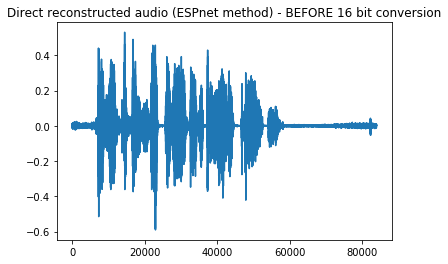

In [4]:
sys.path.insert(0, '/home/iustina/espnet/utils/')
# sys.path.insert(0, '/home/iustina/espnet/')
import convert_fbank_to_wav 

### IA: initially, in below code we would reconstruct the audio from orig_feat_from_json, but we had to change the archive place for each diff utterance, but since these features were very similar with the ones recomputed manually above (feat_recalc), we would just reconstruct from these recalc feats
stft_recon = convert_fbank_to_wav.logmelspc_to_linearspc(feat_recalc, fs=16000, n_mels=80, n_fft=512, fmin=80, fmax=7800)
print("Shape of reconstructed spectrogram like in convert_fbank_to_wav.py ",stft_recon.shape)
wav_recon_espnet = convert_fbank_to_wav.griffin_lim(stft_recon, n_fft=512, n_shift=160, win_length=512, window='hann',  n_iters=64)
print("Shape and max of the direct reconstructed audio with griffin_lin from convert_fbank_to_wav.py are ", wav_recon_espnet.shape, wav_recon_espnet.max())
plt.figure(1)
plt.plot(wav_recon_espnet) 
plt.title("Direct reconstructed audio (ESPnet method) - BEFORE 16 bit conversion")
##### Obs: the direct reconstructed audio from the features is in the interval [-1 1], so we have to multiply it by np.iinfo(np.int16).max = 32768 and save it as type int16 so as to have bit-depth 16

wav_recon_16bit_espnet = (wav_recon_espnet * np.iinfo(np.int16).max)
start=32000
end=32015
print("Values from the reconstructed float 16bit audio ", wav_recon_16bit_espnet[start:end])
wav_recon_16bit_espnet = wav_recon_16bit_espnet.astype(np.int16)
print("Values from the reconstructed int 16bit audio ", wav_recon_16bit_espnet[start:end])
## For comparison, print values from the original audio
print("Values from the original audio ", orig_raw_wav[start:end])
print("Obs. orig wav audio has only inetegers in interval [-2^15 2^15]")

print("Shape, max and min of the reconstructed integer 16-bit audio (after multiplying by 2^15 = 32768) are ", wav_recon_16bit_espnet.shape, wav_recon_16bit_espnet.max(), wav_recon_16bit_espnet.min())
### Obs. before applying astype(int16), the values from wav_recon_16bit were floats in the interval [-32768 32768], and int16 rounds them down to the nearest integer
### Obs2: the length of the reconstructed audio is less than the original: 105920 vs 106000 samples for utterance 1028-20100710-hne-ar-05.wav -> 80 samples are missing, that is half the overlap of 160 samples !!



### !! Important obs: 
If I run the above cell a couple of times, I will always get diff results for the max and min of the reconstructed output after griffin_lim -> meaning that it has a random computation inside. So getting the inverted audio is not a reproducible process !! 
* However the difference in diff outputs is not audible !!

#### From _librosa.core.griffinlim_ documentation:
Given a short-time Fourier transform magnitude matrix (S), the algorithm *randomly initializes phase estimates*, and then alternates forward- and inverse-STFT operations. 

2. Librosa reconstruction (librosa.feature.inverse.mel_to_audio() )

Shape, max and min of the direct reconstructed audio with ESPnet method are  (84000,) 0.53096616 -0.5909353
Shape, max and min of the direct reconstructed audio with Librosa method are   (84000,) 0.5117122 -0.6142319
Values from the ESPnet reconstructed float 16bit audio  [-162 -187 -201 -215 -219 -224 -242 -265 -292 -293 -303 -309 -319 -311
 -320]
Values from the Librosa reconstructed float 16bit audio  [263.10092 293.90637 325.7524  385.52417 456.1081  498.13156 521.2988
 531.3808  555.2064  593.70044 648.20184 669.32153 666.88995 693.3409
 722.4155 ]
Values from the reconstructed int 16bit ESPnet audio  [-162 -187 -201 -215 -219 -224 -242 -265 -292 -293 -303 -309 -319 -311
 -320]
Values from the reconstructed int 16bit Librosa audio  [263 293 325 385 456 498 521 531 555 593 648 669 666 693 722]
Values from the original audio  [-360 -356 -374 -367 -370 -350 -338 -324 -334 -340 -299 -266 -239 -216
 -239]

 OBS. orig wav audio has only integers in interval [-2^15 2^15]
Shape, max and m

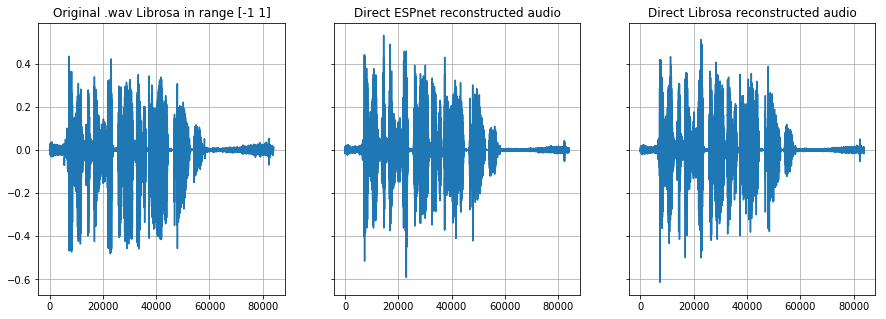

In [5]:
### IA: initially, in below code we would reconstruct the audio from orig_feat_from_json, but we had to change the archive place for each diff utterance, but since these features were very similar with the ones recomputed manually above (feat_recalc), we would just reconstruct from these recalc feats

lin_spc_librosa = np.power(10.0, feat_recalc.T)
### we invert the log that was applied by logmelspectrogram() in the forward feat extr from compute-fbank-feats.py
### ACHTUNG !! I had to transpose the matrix because the stft (linear spectrogram) given as input to librosa must have the shape [n_mels n_frames], as if produced by librosa.feature.melspectrogram()

wav_recon_librosa = librosa.feature.inverse.mel_to_audio(lin_spc_librosa, sr=16000, n_fft=512, hop_length=160, win_length=512, window='hann', power=1.0, n_iter=64, fmin=80, fmax=7800)
print("Shape, max and min of the direct reconstructed audio with ESPnet method are ", wav_recon_espnet.shape, wav_recon_espnet.max(), wav_recon_espnet.min())
print("Shape, max and min of the direct reconstructed audio with Librosa method are  ", wav_recon_librosa.shape, wav_recon_librosa.max(), wav_recon_librosa.min())

# 
# plt.plot(wav_recon_16bit)
#plt.title("Direct reconstructed audio from the features - after 16 bit conversion, before being written to .wav")
# plt.subplot(122)
# plt.plot(wav_recon_reload)
#plt.title("Reconstructed .wav - 16 bit conversion, REALOADED in workspace")
#plt.fig1(figsize=(10, 5))
#fig1 = plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
fig1, (first, second, third) = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(15, 5) )
first.plot(orig_raw_wav_librosa)
first.set_title("Original .wav Librosa in range [-1 1]")
second.plot(wav_recon_espnet)
second.set_title("Direct ESPnet reconstructed audio")
third.plot(wav_recon_librosa) 
third.set_title("Direct Librosa reconstructed audio")
first.grid()
second.grid()
third.grid()

wav_recon_16bit_librosa = (wav_recon_librosa * np.iinfo(np.int16).max)

## Now compare the values for Librosa/ESPnet
print("Values from the ESPnet reconstructed float 16bit audio ", wav_recon_16bit_espnet[start:end])
print("Values from the Librosa reconstructed float 16bit audio ", wav_recon_16bit_librosa[start:end])

wav_recon_16bit_librosa = wav_recon_16bit_librosa.astype(np.int16)

print("Values from the reconstructed int 16bit ESPnet audio ", wav_recon_16bit_espnet[start:end])
print("Values from the reconstructed int 16bit Librosa audio ", wav_recon_16bit_librosa[start:end])
## For comparison, print values from the original audio
print("Values from the original audio ", orig_raw_wav[start:end])
print("\n OBS. orig wav audio has only integers in interval [-2^15 2^15]")

print("Shape, max and min of the reconstructed integer 16-bit audio with ESPnet (after multiplying by 2^15 = 32768) are ", wav_recon_16bit_espnet.shape, wav_recon_16bit_espnet.max(), wav_recon_16bit_espnet.min())
print("Shape, max and min of the reconstructed integer 16-bit audio with Librosa (after multiplying by 2^15 = 32768) are ", wav_recon_16bit_librosa.shape, wav_recon_16bit_librosa.max(), wav_recon_16bit_librosa.min())


#### OBS.
The 2 inversion methods (Librosa and ESPnet - ie. librosa.mel_to_audio() and convert_fbank_to_wav.py) give out different reconstructed audio, and also quite different from the original

We also notice that the begining and end noise of the reconstructed sample for utterance "314piwm-20130617-xuo-b0251" are quite attenuated.

Same story on irreproducible reconstruction results from above holds here too - mel_to_audio() calls griffin_lim, which randomly initializes phases so will give different reconstructed output for each diff call of the func

#### Save the reconstructed audios (Espnet and librosa)

In [6]:
from scipy.io.wavfile import write
write(utt + "_reconstruct-espnet_16bit_26.02.2020.wav", fs, wav_recon_16bit_espnet)
write(utt + "_reconstruct-librosa_16bit_27.02.2020.wav", fs, wav_recon_16bit_librosa)

#### Load it again in the workspace and compute features 
Consider only the esp-net reconstructed audio

In [12]:
fs_reload, wav_recon_reload = read(utt + "_reconstruct-espnet_16bit_26.02.2020.wav")
print("Shape, fs, max and min of the reconstructed 16-bit audio after RELOADING into workspace are: ", wav_recon_reload.shape, fs_reload, wav_recon_reload.max(), wav_recon_reload.min())
## Again for comparison, the same reconstructed 16-bit int wav before being written to .wav file / reloaded
print("Shape, max and min of the reconstructed integer 16-bit audio (after multiplying by 2^15 = 32768), BEFORE reloading/writing to .wav, are: ", wav_recon_16bit_espnet.shape, wav_recon_16bit_espnet.max(), wav_recon_16bit_espnet.min())
### Obs.  These values are exactly the same, so we expect that the reconstructed features will be similar !!

print("# of samples that are not equal between the reconstructed integer 16-bit audio, BEFORE reloading/writing to .wav, and after reloading is: ", sum(wav_recon_16bit_espnet!=wav_recon_reload))

Shape, fs, max and min of the reconstructed 16-bit audio after RELOADING into workspace are:  (84000,) 16000 17398 -19363
Shape, max and min of the reconstructed integer 16-bit audio (after multiplying by 2^15 = 32768), BEFORE reloading/writing to .wav, are:  (84000,) 17398 -19363
# of samples that are not equal between the reconstructed integer 16-bit audio, BEFORE reloading/writing to .wav, and after reloading is:  0


Obs. 

1. We can confirm that the write() fcn wrote the audio data to .wav file correctly, because it reloads audio samples that match the ones before .wav file was saved 

2. The fs of the reloaded audio is correct (16k)

3. Sometimes the number of unequal samples between the reconstructed audio before and after reloading is very high. This happens when different reconstructed audio are compared (because of random phase init in griffin_lim!). But if the same script will be run cell by cell from head to toe, the # of unequal samples would be 0.

Text(0.5,1,'Reconstructed 16 bit .wav, RELOADED in workspace')

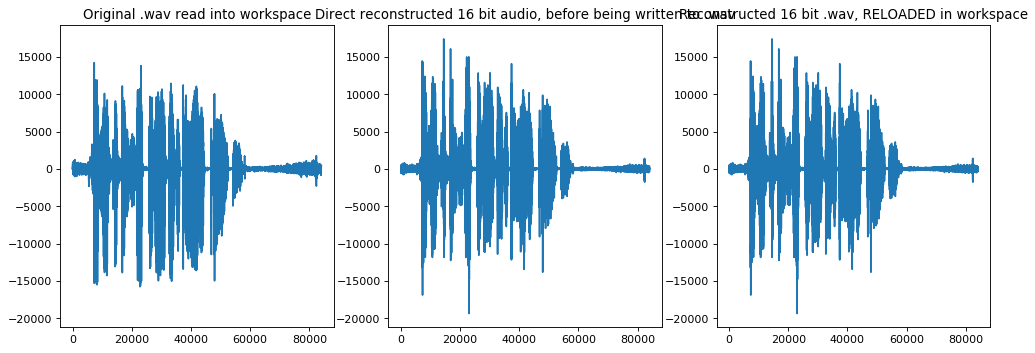

In [9]:
### printing the original and the reloaded wav
#plt.tight_layout()
fig = plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
#fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132, sharey=ax1)
ax3 = fig.add_subplot(133, sharey=ax2)

ax1.plot(orig_raw_wav)
ax1.set_title("Original .wav read into workspace")
ax2.plot(wav_recon_16bit_espnet)
ax2.set_title("Direct reconstructed 16 bit audio, before being written to .wav")
#plt.title("Direct reconstructed audio from the features - after 16 bit conversion, before being written to .wav")
ax3.plot(wav_recon_reload)
ax3.set_title("Reconstructed 16 bit .wav, RELOADED in workspace")
#plt.title("Reconstructed .wav - 16 bit conversion, REALOADED in workspace")

# plt.subplot(121)
# plt.plot(wav_recon_16bit)
#plt.title("Direct reconstructed audio from the features - after 16 bit conversion, before being written to .wav")
# plt.subplot(122)
# plt.plot(wav_recon_reload)
#plt.title("Reconstructed .wav - 16 bit conversion, REALOADED in workspace")


Obs. The reconstructed audio is visibly different than the original .wav 

#### Now build new features from the reconstructed & reloaded wav
To see if the original features match the ones extracted after reconstruction

In [13]:
wav_recon_reload_float32 = wav_recon_reload.astype(np.float32)
## Obs. Based on the values, float16 does just an approximation of the values, while float32 doesn't change them

### Now apply the normalization 
#  array = array / (1 << (args.normalize - 1))
wav_recon_reload_norm = wav_recon_reload_float32 / (1 << (bit_depth-1))

feat_reload_recalc = logmelspectrogram(x=wav_recon_reload_norm, fs=16000, n_mels=80, n_fft=512, n_shift=160,                                                        win_length=512, window="hann", fmin=80, fmax=7800) ##

In [17]:
# print("The shape, max and min values of features from the raw wav utt " + utt_wav + " as computed by run script and stored in .json and .ark files are: ", orig_feat_from_json.shape, orig_feat_from_json.max(), orig_feat_from_json.min())
## orig_feat_from_json is only to be considered for utt 1028-20100710-hne-ar-05

print("The shape, max and min values of recalculated features as in compute-fbank-feats.py (float32, norm, logmelspectrogram) are: ", feat_recalc.shape, feat_recalc.max(), feat_recalc.min())
print("The shape, max and min values of recalculated features from reconstructed and reloaded wav (float32, norm, logmelspectrogram) are: ", feat_reload_recalc.shape, feat_reload_recalc.max(), feat_reload_recalc.min())

print("Values from the original features (recomputed as in compute-fbank-feats.py) ", feat_recalc[300, 40:55])
print("Values from the original features extracted after reconstruction ", feat_reload_recalc[300, 40:55])


The shape, max and min values of recalculated features as in compute-fbank-feats.py (float32, norm, logmelspectrogram) are:  (526, 80) -0.20744471 -4.5401216
The shape, max and min values of recalculated features from reconstructed and reloaded wav (float32, norm, logmelspectrogram) are:  (526, 80) -0.20078579 -4.514046
Values from the original features (recomputed as in compute-fbank-feats.py)  [-1.5301843 -1.372269  -1.3501564 -1.9692401 -2.1130912 -2.1408443
 -2.1015508 -1.9737548 -1.8414451 -1.9111692 -1.9366318 -1.8357428
 -1.5999031 -1.615352  -1.6406782]
Values from the original features extracted after reconstruction  [-1.5116352 -1.3680234 -1.3513732 -1.9821101 -2.1155086 -2.1970456
 -2.1406915 -1.9668071 -1.8581104 -1.9187996 -1.962949  -1.8705955
 -1.6171163 -1.6152339 -1.6408333]


OBS: 

1. Shape of original features and the ones extracted after audio reconstruction is the same.

2. Feature values differ in value by ~0.2 at most. They are similar though

### Next, reconstruct again an audio from these NEW features 
and compare it with the originally reconstructed audio

Shape of the newly reconstructed spectrogram with ESPnet method (steps from convert_fbank_to_wav.py)  (526, 257)
Shape and max of the direct reconstructed audio with griffin_lin from convert_fbank_to_wav.py are  (84000,) 0.5991757
Values from the originally reconstructed float 16bit audio  [-162 -187 -201 -215 -219 -224 -242 -265 -292 -293 -303 -309 -319 -311
 -320]
Values from the NEWLY reconstructed float 16bit audio  [ 368  357  300  263  232  180  149  100   35   -4  -26  -68  -76  -95
 -116]
Shape, max and min of the original reconstructed integer 16-bit audio are  (84000,) 17398 -19363
Shape, max and min of the NEWLY reconstructed integer 16-bit audio are  (84000,) 19633 -16439


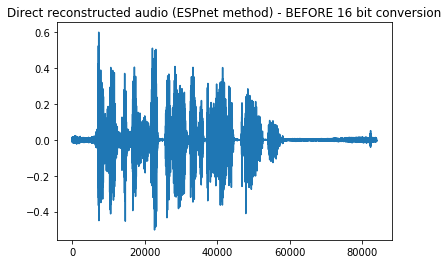

In [18]:
stft_recon_new = convert_fbank_to_wav.logmelspc_to_linearspc(feat_reload_recalc, fs=16000, n_mels=80, n_fft=512, fmin=80, fmax=7800)
print("Shape of the NEWLY reconstructed spectrogram with ESPnet method (steps from convert_fbank_to_wav.py) ",stft_recon_new.shape)
wav_recon_espnet2 = convert_fbank_to_wav.griffin_lim(stft_recon_new, n_fft=512, n_shift=160, win_length=512, window='hann', n_iters=64)
print("Shape and max of the NEWLY direct reconstructed audio with griffin_lin from convert_fbank_to_wav.py are ", wav_recon_espnet2.shape, wav_recon_espnet2.max())
plt.figure(1)
plt.plot(wav_recon_espnet2) 
plt.title("NEWLY direct reconstructed audio (ESPnet method) - BEFORE 16 bit conversion")
##### Obs: the direct reconstructed audio from the features is in the interval [-1 1], so we have to multiply it by np.iinfo(np.int16).max = 32768 and save it as type int16 so as to have bit-depth 16

wav_recon_16bit_espnet2 = (wav_recon_espnet2 * np.iinfo(np.int16).max)
wav_recon_16bit_espnet2 = wav_recon_16bit_espnet2.astype(np.int16)
start=32000
end=32015
print("Values from the originally reconstructed float 16bit audio ", wav_recon_16bit_espnet[start:end])
print("Values from the NEWLY reconstructed float 16bit audio ", wav_recon_16bit_espnet2[start:end])
print("Shape, max and min of the original reconstructed integer 16-bit audio are ", wav_recon_16bit_espnet.shape, wav_recon_16bit_espnet.max(), wav_recon_16bit_espnet.min())
print("Shape, max and min of the NEWLY reconstructed integer 16-bit audio are ", wav_recon_16bit_espnet2.shape, wav_recon_16bit_espnet2.max(), wav_recon_16bit_espnet2.min())

Write this NEWLY reconstructed audio to .wav file

In [19]:
write(utt + "_reconstruct-espnet_16bit_26.02.2020_NEW_recon.wav", fs, wav_recon_16bit_espnet2)

#### Obs. Psycoacoustically, the NEWLY reconstructed audio (from the features taken from the originally reconstructed audio) sounds a bit more ROBOTIC
It remains to be seen whether this impairs the speech recognition 